In [122]:
from loader_findata import Finloader
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable 
import matplotlib.pyplot as plt

In [123]:
f=Finloader(r"C:\Users\Student\UPS2025\UPS2025_FinMat\data\clear_data")

In [124]:
f.close()
for i in tqdm(range(len(f)-30000)):
    f.step()
df=[]
dt=[]
for i in tqdm(range(30000)):
    d,k=f.step()
    dt.append(d)
    df.append(k)

100%|██████████| 30000/30000 [00:19<00:00, 1519.82it/s]


In [125]:
df2=pd.DataFrame(columns=f.get_columns(), data=df,index=dt)

In [126]:
Y=df2[list(filter(lambda x: x[:5]=='close', list(df2.columns)))].shift(-1)/df2[list(filter(lambda x: x[:5]=='close', list(df2.columns)))]

In [127]:
trainX,testX,trainY,testY=train_test_split(df2,Y,shuffle=False)
trainY=trainY.iloc[:-1]
trainX=trainX.iloc[:-1]
testY=testY.iloc[:-1]
testX=testX.iloc[:-1]
trainX=torch.tensor(np.array(trainX),dtype=torch.float32)
trainY=torch.tensor(np.array(trainY),dtype=torch.float32)
testX=torch.tensor(np.array(testX),dtype=torch.float32)
testY=torch.tensor(np.array(testY),dtype=torch.float32)

In [128]:
testX

tensor([[2.4165e+07, 4.8426e+05, 2.4378e+05,  ..., 9.2772e+03, 2.1183e+04,
         4.1611e+04],
        [4.6351e+07, 5.5821e+05, 1.0386e+05,  ..., 2.3524e+04, 7.4199e+04,
         2.4590e+04],
        [1.2596e+08, 9.5033e+05, 2.4017e+05,  ..., 2.2323e+04, 6.9805e+04,
         5.2965e+04],
        ...,
        [2.1005e+07, 2.0324e+05, 8.1328e+04,  ..., 5.4976e+04, 2.9900e+04,
         4.2039e+04],
        [1.9964e+07, 5.3094e+05, 1.3717e+05,  ..., 5.9001e+04, 4.9406e+04,
         6.5303e+04],
        [2.6651e+07, 1.2036e+06, 1.1295e+05,  ..., 1.5425e+05, 7.1073e+04,
         9.2343e+04]])

In [129]:
testY

tensor([[1.0026, 1.0049, 1.0046,  ..., 1.0050, 1.0049, 1.0031],
        [1.0041, 1.0002, 1.0006,  ..., 1.0024, 1.0030, 1.0018],
        [1.0001, 1.0007, 1.0017,  ..., 1.0003, 1.0007, 1.0011],
        ...,
        [0.9990, 1.0017, 1.0029,  ..., 1.0007, 1.0052, 1.0052],
        [1.0006, 1.0006, 1.0034,  ..., 1.0022, 1.0042, 1.0026],
        [1.0008, 1.0017, 1.0008,  ..., 1.0016, 1.0042, 0.9994]])

In [130]:
X_train_tensors_final = torch.reshape(trainX,   (trainX.shape[0], 1, trainX.shape[1]))
Y_train_tensors_final = trainY
X_test_tensors_final = torch.reshape(testX,   (testX.shape[0], 1, testX.shape[1]))
Y_test_tensors_final =  testY

In [131]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [168]:
num_epochs =300 #1000 epochs
learning_rate = 0.0003 #0.001 lr

input_size = 1080 #number of features
hidden_size = 10 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 120 #number of output classes 

In [158]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

In [201]:
def neutralize(alpha):
    return alpha.sub(
        alpha.mean(axis=1),
        axis=0
    )

def scale(alpha):
    return alpha.div(
        alpha
        .abs()
        .sum(axis=1),
        axis=0
    )

def neutralize_tensor(alpha):
    return alpha - alpha.mean().expand_as(alpha)

def normalize_tensor(alpha):
    alpha = alpha / alpha.abs().sum()
    return alpha

In [203]:
from sklearn.metrics import mean_absolute_error as MAE

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, input, target):
        # Compute the loss

        input = normalize_tensor(neutralize_tensor(input))
        return torch.multiply(input, target).sum() / torch.multiply(input, target).std()

criterion = CustomLoss()   
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

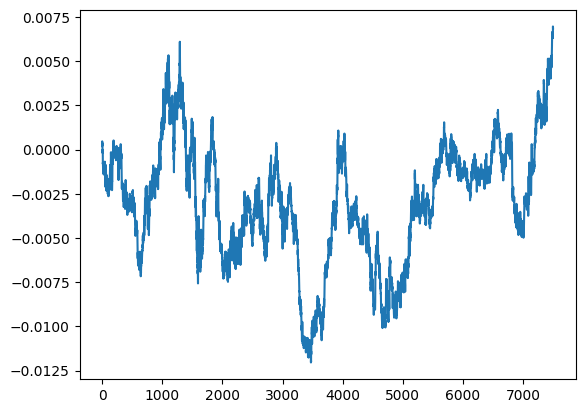

EPOCH: 0; sharpe: -172.2211151123047


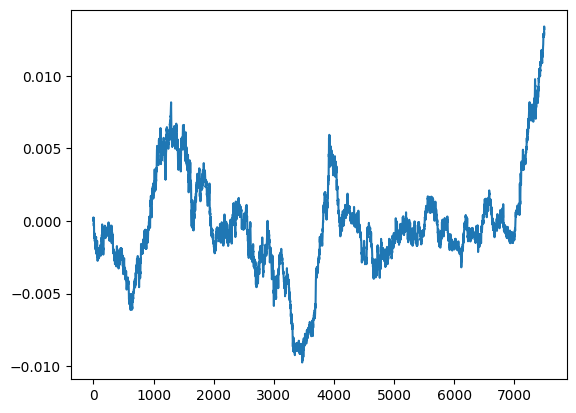

EPOCH: 10; sharpe: -152.77426147460938


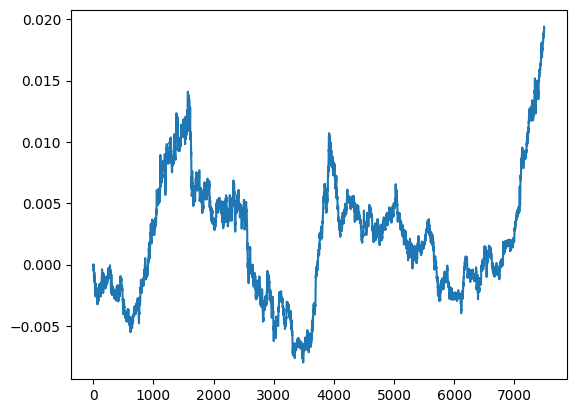

EPOCH: 20; sharpe: -140.70953369140625


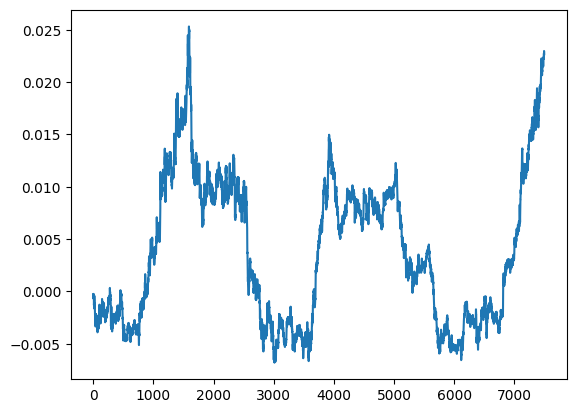

EPOCH: 30; sharpe: -145.3505401611328


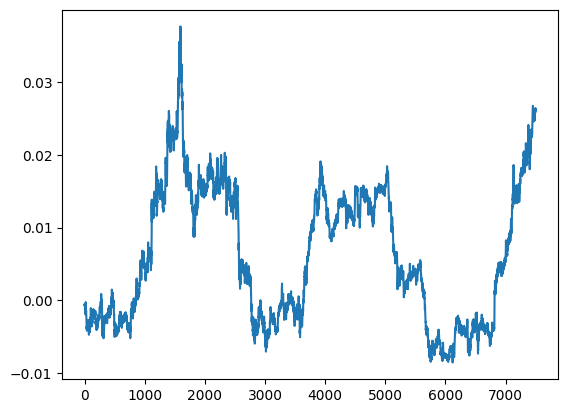

EPOCH: 40; sharpe: -172.16786193847656


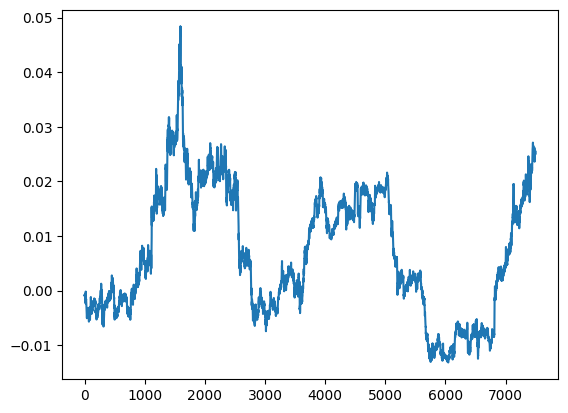

EPOCH: 50; sharpe: -217.68893432617188


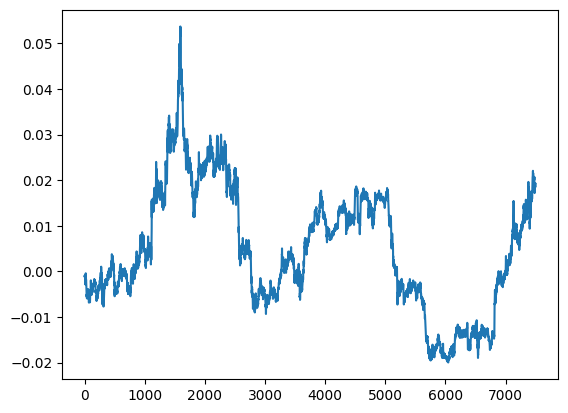

EPOCH: 60; sharpe: -263.7217102050781


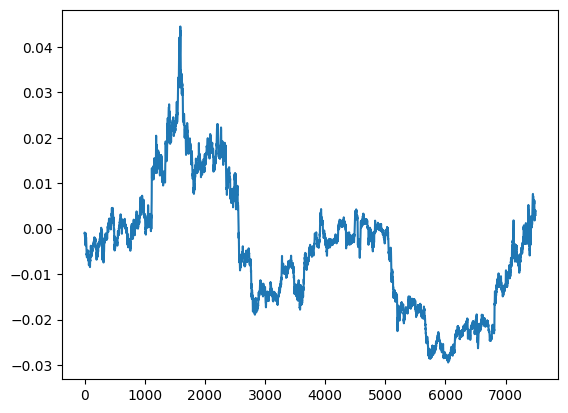

EPOCH: 70; sharpe: -281.0316162109375


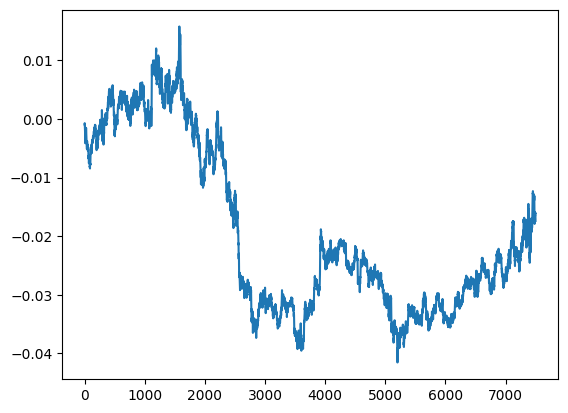

EPOCH: 80; sharpe: -215.0308837890625


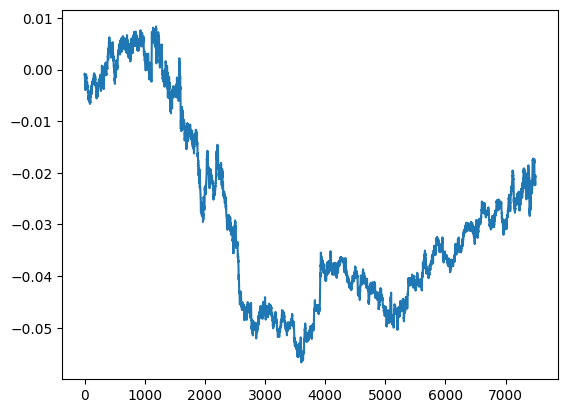

EPOCH: 90; sharpe: -97.38992309570312


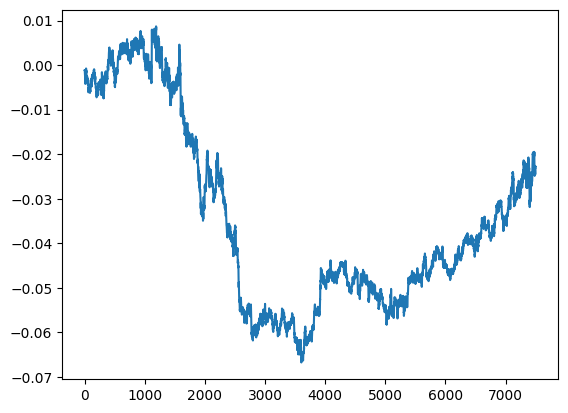

EPOCH: 100; sharpe: -34.3798713684082


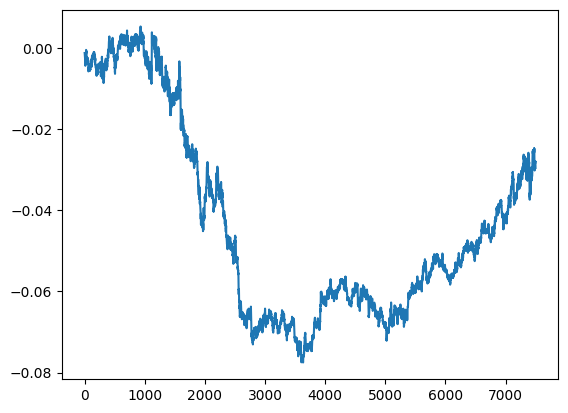

EPOCH: 110; sharpe: -59.34489822387695


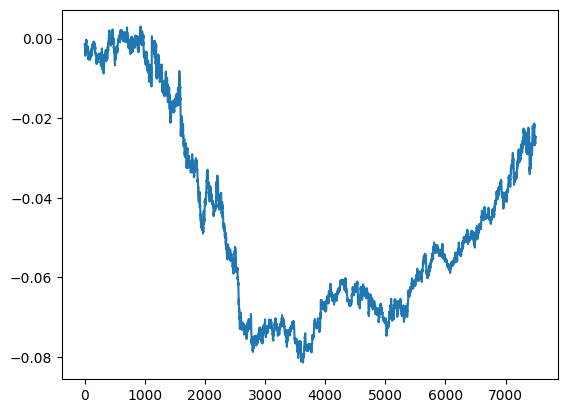

EPOCH: 120; sharpe: -90.57830047607422


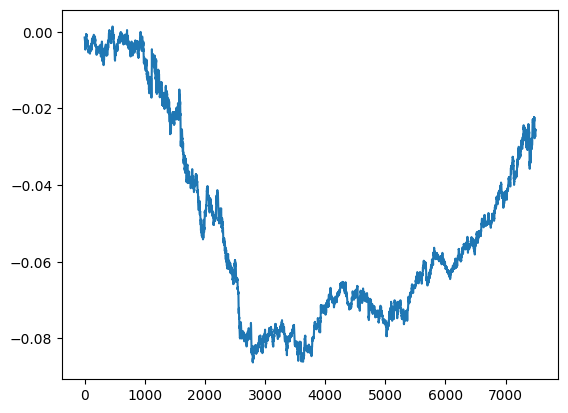

EPOCH: 130; sharpe: -101.646728515625


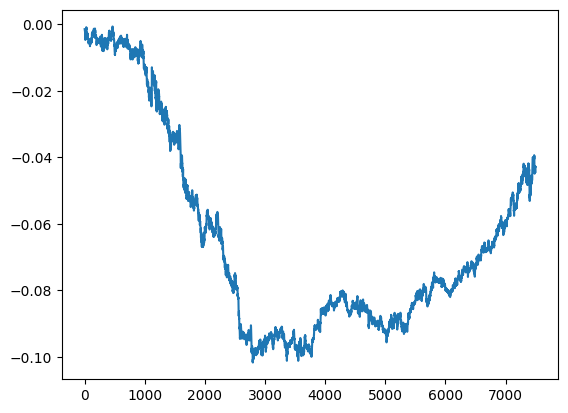

EPOCH: 140; sharpe: -85.63162231445312


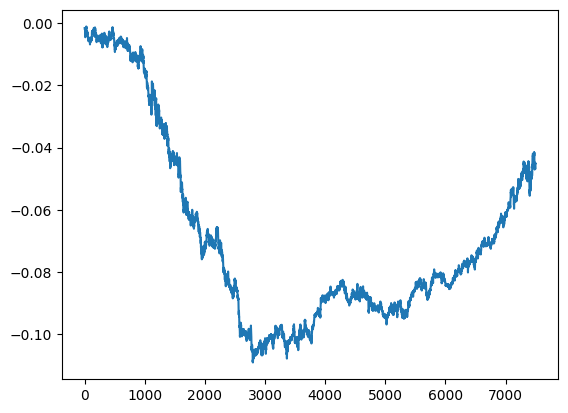

EPOCH: 150; sharpe: -49.44607925415039


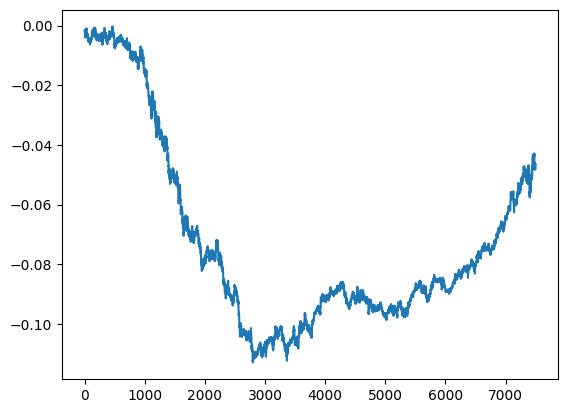

EPOCH: 160; sharpe: -1.9177602529525757


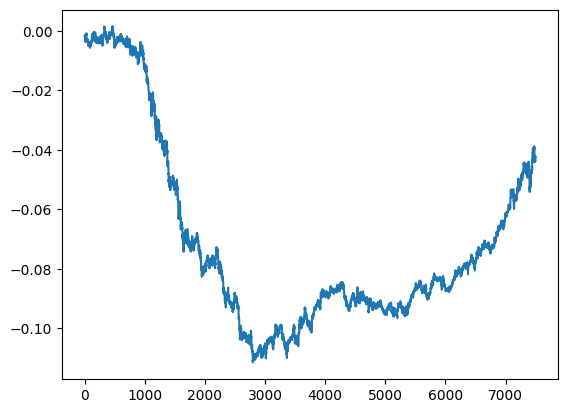

EPOCH: 170; sharpe: 37.784812927246094


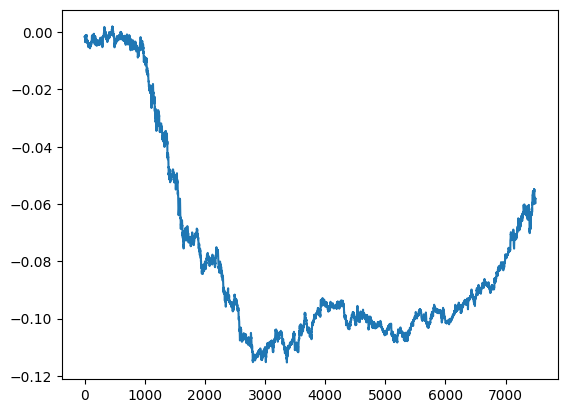

EPOCH: 180; sharpe: 57.93478012084961


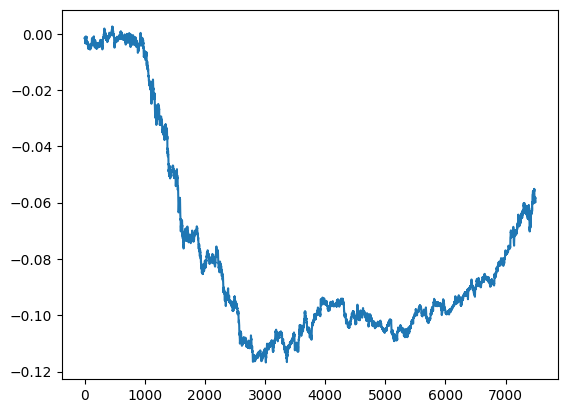

EPOCH: 190; sharpe: 71.55155181884766


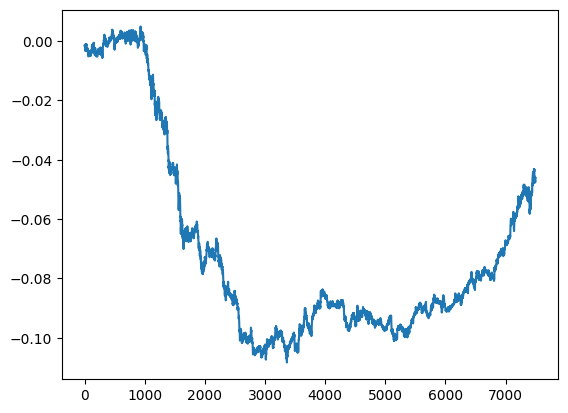

EPOCH: 200; sharpe: 82.27139282226562


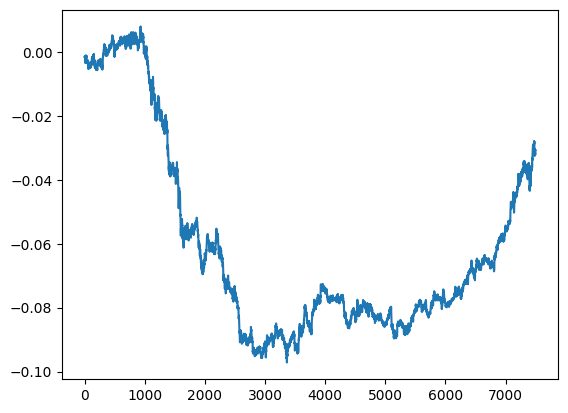

EPOCH: 210; sharpe: 80.38911437988281


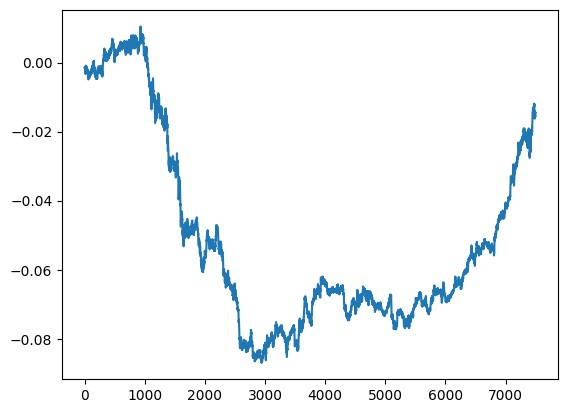

EPOCH: 220; sharpe: 73.89018249511719


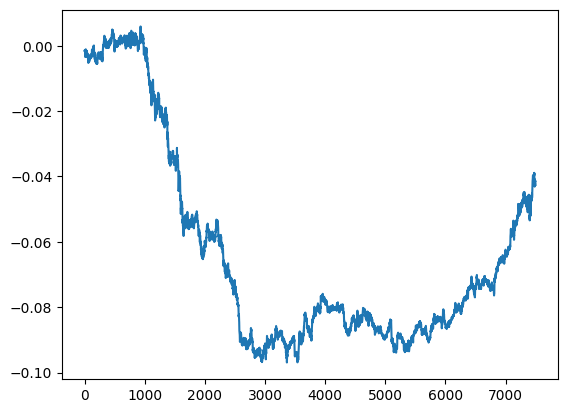

EPOCH: 230; sharpe: 64.89636993408203


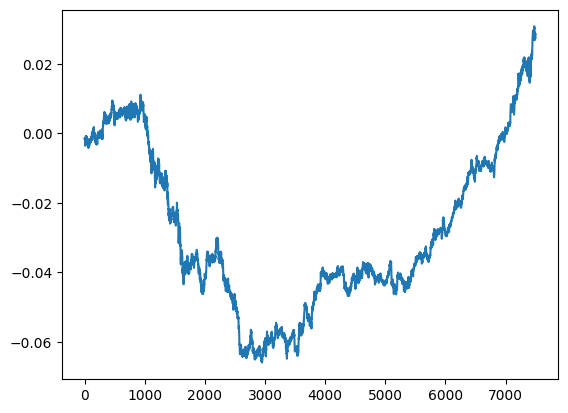

EPOCH: 240; sharpe: 59.12899398803711


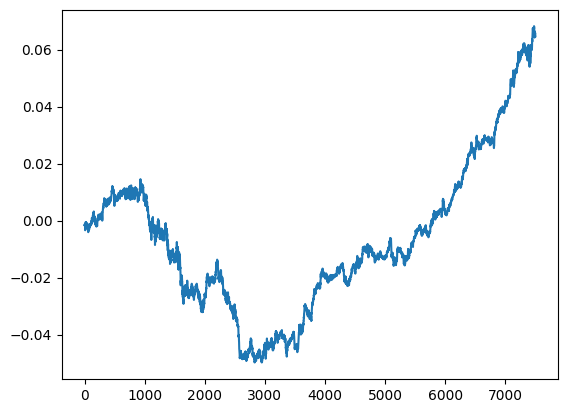

EPOCH: 250; sharpe: 53.8472900390625


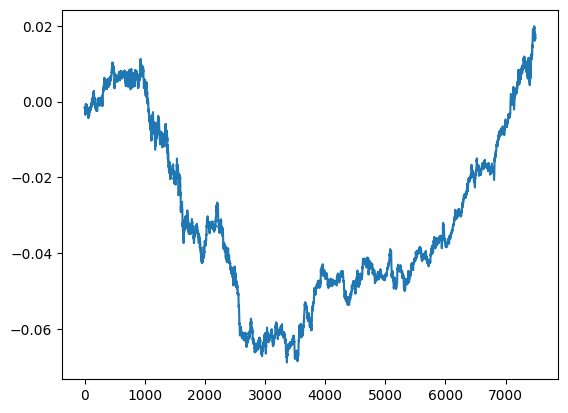

EPOCH: 260; sharpe: 46.993465423583984


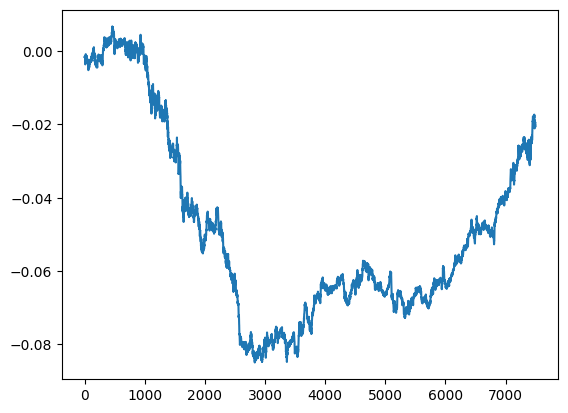

EPOCH: 270; sharpe: 41.17604446411133


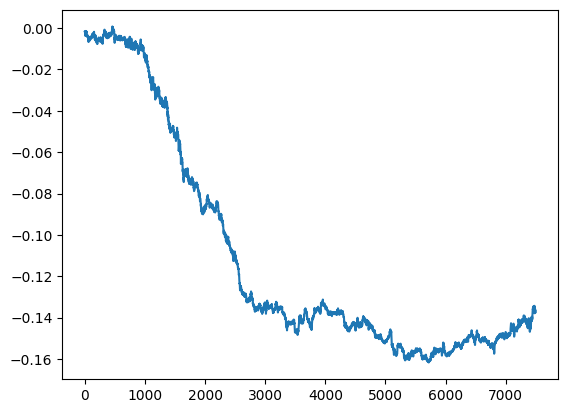

EPOCH: 280; sharpe: 34.86240768432617


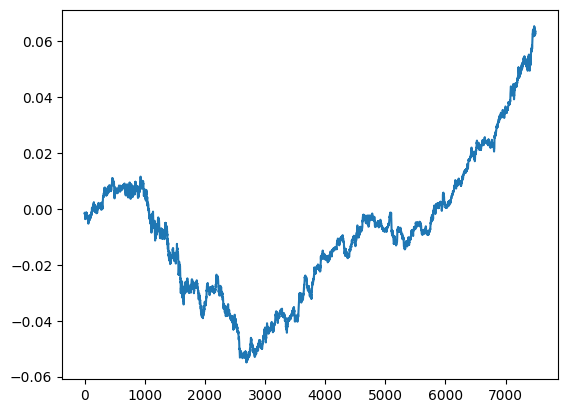

EPOCH: 290; sharpe: 31.79822540283203


In [204]:
from fin_metrics import FinCalculations

train_losses = []
val_maes = []

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, Y_train_tensors_final)
 
  loss.backward() #calculates the loss of the loss function
  train_losses.append(loss.item())
  optimizer.step() #improve from loss, i.e backprop
  
  if epoch % 10 == 0:
    lstm1.eval()
    plt.plot((scale(neutralize(pd.DataFrame(lstm1(X_test_tensors_final).detach().numpy())))*pd.DataFrame(Y_test_tensors_final.detach().numpy())).sum(axis=1).cumsum())
    plt.show()
    val_outputs = lstm1(X_test_tensors_final)
    metr = criterion(Y_test_tensors_final.detach(), val_outputs.detach())
    val_maes.append(metr)
    print(f"EPOCH: {epoch}; sharpe: {metr}")
    lstm1.train()

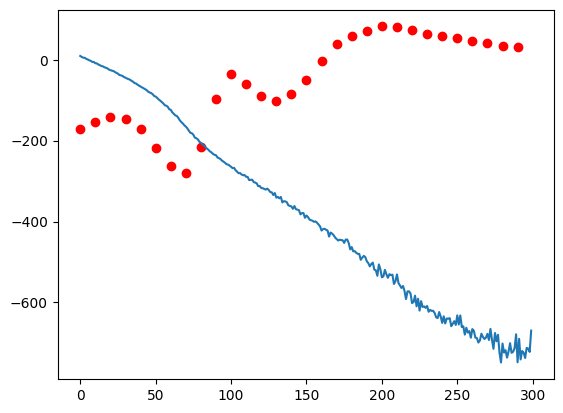

In [205]:
plt.plot(train_losses)
plt.scatter(range(0, num_epochs, 10), val_maes, color='r')

In [165]:
df2[list(filter(lambda x: x[:5]=='close', list(df2.columns)))]

,close_1000SHIBUSDT,close_1000XECUSDT,close_1INCHUSDT,close_AAVEUSDT,close_ADAUSDT,close_ALGOUSDT,close_ALICEUSDT,close_ALPHAUSDT,close_ANKRUSDT,close_ARPAUSDT,...,close_XEMUSDT,close_XLMUSDT,close_XMRUSDT,close_XRPUSDT,close_XTZUSDT,close_YFIUSDT,close_ZECUSDT,close_ZENUSDT,close_ZILUSDT,close_ZRXUSDT
2024-09-27 20:00:00+00:00,0.020229,0.03812,0.3094,167.83,0.4005,0.1442,1.177,0.06760,0.03100,0.04876,...,0.0198,0.09880,162.94,0.5857,0.749,5377.0,30.24,8.707,0.01659,0.3679
2024-09-27 20:05:00+00:00,0.020098,0.03802,0.3088,167.38,0.4001,0.1439,1.172,0.06744,0.03093,0.04867,...,0.0198,0.09866,162.87,0.5845,0.749,5372.0,30.15,8.702,0.01656,0.3667
2024-09-27 20:10:00+00:00,0.020222,0.03806,0.3092,167.72,0.4007,0.1442,1.177,0.06756,0.03092,0.04863,...,0.0198,0.09887,162.66,0.5848,0.750,5364.0,30.17,8.710,0.01660,0.3672
2024-09-27 20:15:00+00:00,0.020214,0.03797,0.3093,167.82,0.4010,0.1440,1.176,0.06751,0.03091,0.04856,...,0.0198,0.09894,162.76,0.5851,0.749,5361.0,30.19,8.706,0.01658,0.3666
2024-09-27 20:20:00+00:00,0.020283,0.03792,0.3091,167.91,0.4011,0.1441,1.175,0.06749,0.03088,0.04858,...,0.0198,0.09910,162.79,0.5855,0.749,5361.0,30.20,8.725,0.01659,0.3665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-09 23:35:00+00:00,0.021028,0.03594,0.3839,280.69,0.9040,0.3417,1.094,0.07277,0.03529,0.04537,...,0.0338,0.39140,190.20,2.2737,1.259,7853.0,46.87,23.604,0.02114,0.4984
2025-01-09 23:40:00+00:00,0.021024,0.03593,0.3839,280.29,0.9042,0.3413,1.095,0.07287,0.03534,0.04537,...,0.0338,0.39062,190.29,2.2709,1.266,7857.0,46.89,23.612,0.02116,0.4999
2025-01-09 23:45:00+00:00,0.021004,0.03599,0.3850,280.69,0.9042,0.3422,1.097,0.07294,0.03541,0.04545,...,0.0338,0.39140,190.51,2.2737,1.272,7854.0,46.87,23.629,0.02127,0.5025
2025-01-09 23:50:00+00:00,0.021017,0.03601,0.3863,280.62,0.9046,0.3418,1.099,0.07316,0.03554,0.04555,...,0.0338,0.39098,190.80,2.2735,1.272,7867.0,46.90,23.680,0.02136,0.5038


In [140]:
df2.to_csv("last_30_rows.csv")

In [147]:
def neutralize(alpha):
  return alpha.subtract(
    alpha.mean(axis=1),
    axis=0
  )

def scale(alpha):
  return alpha.div(
    alpha
    .abs()
    .sum(axis=1),
    axis=0
  )

<Axes: >

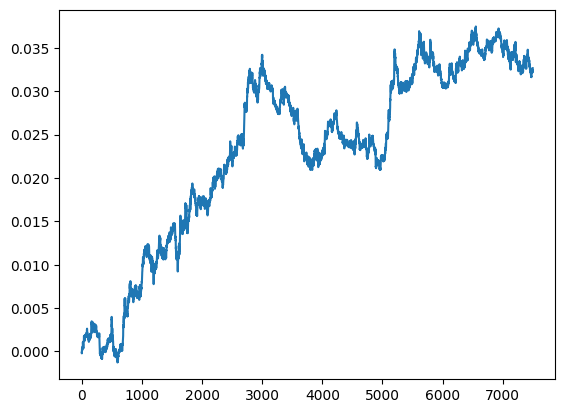

In [288]:
pd.DataFrame(X_test_tensors_final.reshape(7499,1080))

,0,1,2,3,4,5,6,7,8,9,...,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079
0,24165040.0,484265.0,243777.0,3525.000000,1998178.0,1.526689e+06,38826.699219,376838.0,679354.0,394575.0,...,0.0,3.616397e+05,19506.158203,2865699.750,31118.912109,115291.125000,19370.292969,9277.153320,21183.052734,41610.718750
1,46350768.0,558211.0,103855.0,2043.099976,1201952.0,1.790800e+06,39706.601562,196204.0,299027.0,127555.0,...,0.0,2.483018e+05,7813.066895,2805062.250,41707.968750,38317.593750,22766.708984,23523.763672,74198.789062,24590.423828
2,125964168.0,950332.0,240169.0,2942.500000,2089811.0,1.318456e+06,60818.601562,444622.0,1277439.0,431117.0,...,0.0,1.390868e+06,67537.468750,5173458.500,38473.097656,119827.093750,124784.570312,22322.984375,69805.484375,52965.425781
3,76067432.0,696757.0,215115.0,2341.899902,2442171.0,1.121037e+06,31004.300781,681332.0,423815.0,386666.0,...,0.0,1.679712e+06,73090.781250,2615121.250,75709.406250,45859.445312,29714.761719,11417.347656,18161.355469,30433.730469
4,25848464.0,269051.0,143460.0,1541.900024,1810649.0,2.964851e+06,17936.099609,122552.0,154146.0,380573.0,...,0.0,8.280490e+05,38225.648438,2651413.000,38033.406250,28543.826172,44850.003906,19886.224609,24038.031250,27998.957031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7494,21842922.0,484352.0,93230.0,1983.800049,1009006.0,4.365876e+05,22109.800781,218926.0,756860.0,295742.0,...,0.0,3.926642e+05,1999.883789,2103638.250,56169.687500,22342.490234,20398.984375,59276.164062,13418.401367,72684.117188
7495,16313313.0,274281.0,101536.0,942.200012,769247.0,8.902292e+05,22749.099609,132103.0,837015.0,90456.0,...,0.0,1.745867e+05,10922.804688,964148.500,76885.695312,30641.117188,9283.379883,72345.984375,28258.517578,76874.585938
7496,21004634.0,203236.0,81328.0,775.500000,511836.0,2.671054e+05,7240.600098,225467.0,1323886.0,125089.0,...,0.0,4.163663e+05,25856.099609,1615391.625,69756.773438,13515.638672,27353.046875,54976.484375,29900.138672,42039.089844
7497,19964302.0,530940.0,137166.0,1009.900024,626002.0,2.692337e+05,6456.600098,138372.0,3090722.0,108307.0,...,0.0,3.189297e+05,7202.064941,1430041.750,100232.593750,16928.320312,9574.912109,59001.269531,49406.128906,65302.953125


In [290]:
pd.DataFrame(Y_test_tensors_final)

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,1.002600,1.004868,1.004616,1.006284,1.002654,1.001193,1.002647,1.003530,1.004273,1.002970,...,1.0,1.004104,1.001400,1.001127,1.004286,1.004594,1.003445,1.004973,1.004874,1.003117
1,1.004091,1.000231,1.000627,1.002036,1.001796,1.001906,1.000660,1.001759,1.002015,1.001974,...,1.0,1.004729,1.001495,0.999958,1.001423,1.001773,1.003605,1.002373,1.002985,1.001799
2,1.000073,1.000692,1.001670,0.999675,1.001132,0.998573,1.000660,0.998891,1.000670,1.000493,...,1.0,1.004399,1.000770,1.001542,1.000710,1.000932,1.000342,1.000338,1.000744,1.001143
3,0.998618,0.999078,0.998541,0.996422,0.998775,1.004525,0.999341,0.998797,0.998660,0.999015,...,1.0,0.999199,1.001684,0.999292,0.997871,0.999442,1.001710,0.998715,0.997770,0.996739
4,1.002113,1.002076,1.000209,0.998232,1.001416,0.999763,1.001319,1.002130,1.001342,1.001478,...,1.0,1.002640,1.001681,1.001083,1.000711,1.000093,1.001195,1.000338,1.001118,1.000982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7494,0.998244,1.000000,1.001304,1.001034,0.998674,0.998247,1.000000,0.999176,1.004269,1.000000,...,1.0,0.997655,0.996960,0.998375,1.000000,0.998220,0.999147,0.999238,1.001421,1.004434
7495,0.999810,0.999722,1.000000,0.998575,1.000221,0.998829,1.000914,1.001374,1.001417,1.000000,...,1.0,0.998007,1.000473,0.998769,1.005560,1.000509,1.000427,1.000339,1.000946,1.003010
7496,0.999049,1.001670,1.002865,1.001427,1.000000,1.002637,1.001827,1.000961,1.001981,1.001763,...,1.0,1.001997,1.001156,1.001233,1.004739,0.999618,0.999573,1.000720,1.005198,1.005201
7497,1.000619,1.000556,1.003377,0.999751,1.000442,0.998831,1.001823,1.003016,1.003671,1.002200,...,1.0,0.998927,1.001522,0.999912,1.000000,1.001655,1.000640,1.002158,1.004231,1.002587


In [291]:
pd.DataFrame(lstm1(X_test_tensors_final).detach().numpy())

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,1.003722,1.003174,1.004816,1.001722,1.001397,1.004357,1.003636,0.999740,1.002984,0.998411,...,1.001735,0.994537,0.997503,1.002396,0.999203,0.995597,0.996891,1.002946,0.999835,0.999265
1,0.999574,1.001221,0.999954,1.000735,0.999826,0.999835,0.998925,0.998557,1.001156,1.000825,...,1.000508,0.999555,1.000096,0.999690,0.999964,1.000797,0.999820,1.000342,1.000293,0.999469
2,0.986647,0.960129,0.974112,0.972502,1.004163,0.989286,1.010103,1.037243,0.961506,0.995107,...,0.984095,1.028153,1.008734,0.997940,1.010509,1.019098,1.023119,0.985764,0.994966,1.020701
3,0.999574,1.001221,0.999954,1.000735,0.999826,0.999835,0.998925,0.998557,1.001156,1.000825,...,1.000508,0.999555,1.000096,0.999690,0.999964,1.000797,0.999820,1.000342,1.000293,0.999469
4,0.999574,1.001221,0.999954,1.000735,0.999826,0.999835,0.998925,0.998557,1.001156,1.000825,...,1.000508,0.999555,1.000096,0.999690,0.999964,1.000797,0.999820,1.000342,1.000293,0.999469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7494,1.003722,1.003174,1.004816,1.001722,1.001397,1.004357,1.003636,0.999740,1.002984,0.998411,...,1.001735,0.994537,0.997503,1.002396,0.999203,0.995597,0.996891,1.002946,0.999835,0.999265
7495,0.996101,1.000227,0.996356,0.997770,1.001863,1.001415,0.999282,0.998437,0.999452,0.999633,...,1.000115,0.999005,0.999089,1.000914,0.999275,1.003287,0.999762,1.000379,1.001055,1.002032
7496,1.003722,1.003174,1.004816,1.001722,1.001397,1.004357,1.003636,0.999740,1.002984,0.998411,...,1.001735,0.994537,0.997503,1.002396,0.999203,0.995597,0.996891,1.002946,0.999835,0.999265
7497,0.996101,1.000227,0.996356,0.997770,1.001863,1.001415,0.999282,0.998437,0.999452,0.999633,...,1.000115,0.999005,0.999089,1.000914,0.999275,1.003287,0.999762,1.000379,1.001055,1.002032
